# John Hopkins & Google Data COVID-19 Model

Creating a functional machine learning model of the spread of COVID-19 based on Google's Community Mobility Reports 

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D #to define a custom legend
import seaborn as sns

import datetime

# Feature Engineering
from scipy.signal import savgol_filter

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Model prep
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Read in data

In [3]:
dfJ_import = pd.read_csv('JH_2020-05-22.csv')
dfG = pd.read_csv('Global_Mobility_Report_2020-05-21.csv', sep=',', low_memory=False)

#dfJ.head()
#dfG.head()

## Rearrange John Hopkins data

The John Hopkins dataset is not in 'Tidy Format' so here I have crudely manipulated it into a more useful format

In [4]:
dfJ_import.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,132,136,153,168,169,173,178,187,193,205
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,522,529,536,542,548,555,561,568,575,582
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,49,49,49,51,51,51,51,51,51,51
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,3,3,3,3,3


Get a list of contries with country level data (i.e. no Province/State data)

In [5]:
index = pd.isnull(dfJ_import[['Province/State']]).any(1).to_numpy().nonzero()[0]

And split the imported dataset into country level data (dfJ_t) and 'Province/State' level data (dfJ_import_r)

In [6]:
temp = pd.DataFrame()

dfJ_t = dfJ_import.loc[index,:]
dfJ_import_r = dfJ_import.drop(index)

dfJ_t = dfJ_t.drop(columns = ['Province/State', 'Lat', 'Long']) #Not using these columns so drop them
dfJ_t.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,132,136,153,168,169,173,178,187,193,205
1,Albania,0,0,0,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,Algeria,0,0,0,0,0,0,0,0,0,...,522,529,536,542,548,555,561,568,575,582
3,Andorra,0,0,0,0,0,0,0,0,0,...,49,49,49,51,51,51,51,51,51,51
4,Angola,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,3,3,3,3,3


If there is no country level data available for a 'State/Province' (e.g. China where the data is broken down to each individual state), sum the available data and append the country's name into dfJ, otherwise create a new 'Country/Region' to group all these 'State/Province's

In [7]:
stateCountries = dfJ_import_r['Country/Region'].unique()

temp = pd.DataFrame(columns = dfJ_t.columns)

for x in stateCountries:
    
    if x in dfJ_t['Country/Region'].unique():
    
        temp.loc[0,'Country/Region'] = x + ' Overseas Territories' 
        #Apologies if 'Overseas Territories' is not an appropriate term in some cases.
        #I've used it because 'British Overseas Territories' is the general term used for the UK countries so I've generalised
    else:
        temp.loc[0,'Country/Region'] = x
    
    for y in dfJ_t.columns[1:]:
        temp.loc[0,y] = sum(dfJ_import_r[dfJ_import_r['Country/Region'] == x][y])
    
    dfJ_t = dfJ_t.append(temp, ignore_index=True)

'Rotate' the data so that it's closer to 'Tidy Format' 

In [8]:
variable = dfJ_t['Country/Region'].values
dfJ = pd.DataFrame(columns = variable)
dfJ.reset_index()
#n_dfJ.drop(columns='Country/Region')
dfJ['Date'] = dfJ_t.columns[1:]

for x in dfJ.columns[0:-1]:
    
    dfJ_index, = np.where(dfJ_t['Country/Region'][:].values == x)[0]
    dfJ.loc[:,x] = dfJ_t.iloc[dfJ_index][1:].values

### Reorder so Date is the first column in the Data Frame
temp = dfJ.pop('Date')
dfJ.insert(0, 'Date', temp)
dfJ.head()

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Austria,...,Comoros,Tajikistan,Lesotho,Australia,Canada,China,Denmark Overseas Territories,France Overseas Territories,Netherlands Overseas Territories,United Kingdom Overseas Territories
0,1/22/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,17,0,0,0,0
1,1/23/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,18,0,0,0,0
2,1/24/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,26,0,0,0,0
3,1/25/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,42,0,0,0,0
4,1/26/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,56,0,0,0,0


The 'Diamond Princess' isn't a country so... Remove it. 

More seriously, in most countries the number of infections are vastly lower than the total population. This wasn't the case on the Diamond Princess so I believe it could be tricky data to interpret

In [9]:
dfJ = dfJ.drop(columns = 'Diamond Princess')

Specify that 'Date' is in datetime format

In [10]:
dfJ["Date"] = pd.to_datetime(dfJ["Date"], format='%m/%d/%y')

## Update Google Data

Google's Mobility Report data is in tidy format so only small changes are needed:

Rename columns to be consistent

In [11]:
dfG = dfG.rename(columns={"country_region": "Country", "date": "Date"})

And specify that the dates are datetime format

In [12]:
dfG["Date"] = pd.to_datetime(dfG["Date"])

#dfG.dtypes

# Remove unnecessary / unused columns

## John Hopkins data

### Rename headers

As this data will be merged with Google's, it's important countries have exactly the same names

In [13]:
dfJ = dfJ.rename(columns={"US": "USA", "Taiwan*":"Taiwan"})

### Remove countries with a 'small' number of cases

This model focuses on countries with, relatively speaking, a larger number of cases so this step removes other countries

In [14]:
limitCount = 3000 # minimum count to not be discounted

lowDeaths = pd.DataFrame()
for x in list(dfJ.columns[1:]): #Starts at 1 to ignore 'Date'
    if max(dfJ[x][:])<=limitCount:
        temp = dfJ.pop(x)
        lowDeaths[temp.name] = temp

#dfJ.head()
#lowDeaths.head()

### Change to 'tidy' format

In [15]:
trimmedDf = pd.DataFrame(columns = ['Country', 'Deaths'])

temp = pd.DataFrame()#columns = ['Day_0', 'Country', 'Deaths'])
#for loop loops through countries. Skips index 0 as that's the date (not a country...)
for x in list(dfJ.columns[1:]):
    
    nonZero = dfJ[x].to_numpy().nonzero()
    firstVal = nonZero[0][0]
    tempList = list(dfJ[x][firstVal:])
    
    #temp[dayVal] = range(1,len(tempList)+1)
    temp['Country'] = [x] * (len(tempList))
    temp['Date'] = list(dfJ['Date'][firstVal:])
    temp['Deaths'] = tempList
    
    trimmedDf = trimmedDf.append(temp, ignore_index=True, sort=True)
    temp = temp.iloc[0:0] #reset temp

dfJ = trimmedDf.copy()  
del trimmedDf, temp
dfJ.head()

,Country,Date,Deaths
0,Belgium,2020-03-11,3
1,Belgium,2020-03-12,3
2,Belgium,2020-03-13,3
3,Belgium,2020-03-14,4
4,Belgium,2020-03-15,4


## Google data
We're only using the country level data, so removing sub-regions 

In [16]:
dfG = dfG.drop(dfG.index[pd.notna(dfG['sub_region_1'])]) # Remove all not-empty subregion rows
dfG = dfG.drop(columns=['sub_region_1', 'sub_region_2', 'country_region_code']) # Remove unnecessary columns

### Rename Countries

As this data will be merged with John Hopkins' it's important that countries are named consistently

In [17]:
dfG.loc[(dfG['Country'] == 'United States'),'Country'] = 'USA'

### Rename headers
Just to neaten things up for later (when plotting anything), I'm shortening the column titles

In [18]:
dfG = dfG.rename(columns={"retail_and_recreation_percent_change_from_baseline": "Retail and Recreation",
                          "grocery_and_pharmacy_percent_change_from_baseline":"Grocery and Pharmacy", 
                          "parks_percent_change_from_baseline":"Parks", 
                          "transit_stations_percent_change_from_baseline":"Transit Stations", 
                          "workplaces_percent_change_from_baseline":"Workplaces",
                          "residential_percent_change_from_baseline": "Residential"})

#dfG.head()

# Feature 'Engineering'
Turning the features into something more useful

Not the most efficient, but I do this before merging the John Hopkins and Google datasets because you lose a few dates when merging the data.

While it would be more computationally efficient to calculate each of the following in the same loop, I have decided to split them out for legibility.

## Calculate the number of new deaths per day

In [19]:
dfJ['dDeaths'] = np.nan

#Loop through all unique countries
for x in dfJ['Country'].unique(): 
    indexList = dfJ[dfJ.Country == x]['Deaths'].index.values.astype(int)
    
    #Loop through all recordings for that country   
    for y in indexList[1:]: 
        dfJ.loc[y, 'dDeaths'] = dfJ.loc[y, 'Deaths'] - dfJ.loc[(y-1), 'Deaths']
        
        #Some countries have abruptly revised upwards their estimates of death. 
        #To avoid introducing a random peak in the data, I've added this check to replace the value with the average of the one before and after
        if dfJ.loc[y, 'dDeaths'] > 1000 and dfJ.loc[y, 'dDeaths'] > 100 * abs(dfJ.loc[y-1, 'dDeaths']):
            dfJ.loc[y, 'dDeaths'] = ((dfJ.loc[y-1, 'dDeaths']) + (dfJ.loc[y+1, 'Deaths'] - dfJ.loc[(y), 'Deaths']))/2
      

 #Remove NaNs left from the first row for each country
dfJ = dfJ.dropna().reset_index(drop = True)
dfJ['dDeaths'] = dfJ['dDeaths'].dropna().astype(int)        
dfJ.head()

,Country,Date,Deaths,dDeaths
0,Belgium,2020-03-12,3,0
1,Belgium,2020-03-13,3,0
2,Belgium,2020-03-14,4,1
3,Belgium,2020-03-15,4,0
4,Belgium,2020-03-16,5,1


### Pass this through a filter to remove the 'noise'

The JH data presents the number of new deaths reported by the government on a day, but not the date it they actually occur. Therefore there is a bit of 'noise' on this data as reporting increases and decreases during a working week. 

Filtering this aims to remove this 'noise'.

I have chosen a 7 day rolling mean as I noticed some filters struggled fitting at the end of the data (and the results were overly influenced by noise)

In [20]:
dfJ['dDeaths_filtered'] = np.nan
rollingAv = 7


for x in dfJ['Country'].unique(): #Loop through all unique countries
    
    indexList = dfJ[dfJ.Country == x]['dDeaths'].index
    
    if len(indexList) < rollingAv:
        
        for y in range(0,len(indexList)):    
            dfJ.loc[indexList[y],'dDeaths_filtered'] = dfJ.loc[min(indexList):indexList[y],'dDeaths'].mean()
    
    else:
        
        for y in range(0,rollingAv):            
            dfJ.loc[indexList[y],'dDeaths_filtered'] = dfJ.loc[min(indexList):indexList[y],'dDeaths'].mean()
            
        for y in range(rollingAv,len(indexList)):            
            dfJ.loc[indexList[y],'dDeaths_filtered'] = dfJ.loc[indexList[y-rollingAv+1]:indexList[y],'dDeaths'].mean()

dfJ.head()

,Country,Date,Deaths,dDeaths,dDeaths_filtered
0,Belgium,2020-03-12,3,0,0.000000
1,Belgium,2020-03-13,3,0,0.000000
2,Belgium,2020-03-14,4,1,0.333333
3,Belgium,2020-03-15,4,0,0.250000
4,Belgium,2020-03-16,5,1,0.400000


### Divide by the total deaths

In [21]:
dfJ['dDeaths_f/total'] = dfJ['dDeaths_filtered'] / dfJ['Deaths']

## Calculate the rate of change of new reported deaths

In [22]:
dfJ['dd_Deaths'] = np.nan

#Loop through all unique countries
for x in dfJ['Country'].unique(): 
    
    indexList = dfJ[dfJ.Country == x]['dDeaths'].index.values.astype(int)
    
    dfJ.loc[indexList[0],'dd_Deaths'] = dfJ.loc[indexList[0], 'dDeaths_filtered']
    
    for y in indexList[1:]:
        dfJ.loc[y,'dd_Deaths'] = dfJ.loc[y, 'dDeaths_filtered'] - dfJ.loc[y-1, 'dDeaths_filtered']

#dfJ.head()

And filter this data as well

Note: I have effectively removed this filter (setting the rolling average to include just 1 day) as it seemed to overly dampen the data. I've left this step in in case a better solution appears in the future

In [23]:
dfJ['dd_Deaths_filtered'] = np.nan

#Loop through all unique countries
for x in dfJ['Country'].unique(): 
    
    indexList = dfJ[dfJ.Country == x]['dd_Deaths'].index.values.astype(int)
    
    dfJ.loc[indexList,'dd_Deaths_filtered'] = savgol_filter(dfJ[dfJ.Country == x]['dd_Deaths'], 15, 3)

dfJ['dd_Deaths_filtered'] = np.nan
rollingAv2 = 1

for x in dfJ['Country'].unique(): #Loop through all unique countries
    
    indexList = dfJ[dfJ.Country == x]['dd_Deaths'].index
    
    if len(indexList) < rollingAv2:
        
        for y in range(0,len(indexList)):    
            dfJ.loc[indexList[y],'dd_Deaths_filtered'] = dfJ.loc[min(indexList):indexList[y],'dd_Deaths'].mean()
    
    else:
        
        for y in range(0,rollingAv2):            
            dfJ.loc[indexList[y],'dd_Deaths_filtered'] = dfJ.loc[min(indexList):indexList[y],'dd_Deaths'].mean()
            
        for y in range(rollingAv2,len(indexList)):            
            dfJ.loc[indexList[y],'dd_Deaths_filtered'] = dfJ.loc[indexList[y-rollingAv2]:indexList[y],'dd_Deaths'].mean()
dfJ.head()

And divide by dDeaths_filtered to 'Normalise' it

In [24]:
dfJ['dd_Deaths_f/dDeaths_f'] = dfJ['dd_Deaths_filtered'] / dfJ['dDeaths_filtered']

Data at the early stage of an outbreak can be unreliable and so noisy so this step removes it (see loop below)

In [25]:
minD = 100
dayVal = 'Day_' + str(minD)
dfJ[dayVal] = -1

for x in dfJ['Country'].unique():
    countryIndex = dfJ[dfJ['Country'] == x].index
    
    for y in countryIndex:
        if dfJ.loc[y,'Deaths'] < minD:
            dfJ.loc[y,dayVal] = np.nan
            
        else:
            dfJ.loc[y:max(countryIndex), dayVal] = list(map(round, range(0,(max(countryIndex)-y+1))))
            break

#This removes all the NANs (from below the minimum value), as well as all infinities from dividing by zero (caused 7 consecutive days of no change in deaths)
dfJ = dfJ.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

# Merge Data

## Pre-Merge Feature Engineering
Google's dataset should be in some way proportional to the daily infections. I'm also assuming the number of deaths is (roughly) proportional to the number of infections. 

However, deaths do not occur on the same day as an infection but are offset. So, I'm assuming a 21 day offset

In [26]:
dayOffset = 21
dfG_offset = dfG.copy()
dfG_offset['Date'] = dfG['Date'] + datetime.timedelta(days=dayOffset)
#I label this dfG_offset because I occasionally check which offset generates the best model. 
#It's unhelpful having to re-run absolutely everything 

## Merging

In [27]:
df = pd.merge(dfJ, dfG_offset, on=['Country', 'Date'])
df.head()

,Country,Date,Deaths,dDeaths,dDeaths_filtered,dDeaths_f/total,dd_Deaths,dd_Deaths_filtered,dd_Deaths_f/dDeaths_f,Day_100,Retail and Recreation,Grocery and Pharmacy,Parks,Transit Stations,Workplaces,Residential
0,Belgium,2020-03-24,122,34,16.000000,0.131148,4.142857,3.289407,0.205588,0.0,2.0,6.0,11.0,1.0,4.0,0.0
1,Belgium,2020-03-25,178,56,23.428571,0.131621,7.428571,4.954363,0.211467,1.0,1.0,4.0,7.0,1.0,4.0,0.0
2,Belgium,2020-03-26,220,42,28.428571,0.129221,5.000000,5.694893,0.200323,2.0,-4.0,1.0,-16.0,-2.0,2.0,2.0
3,Belgium,2020-03-27,289,69,36.000000,0.124567,7.571429,7.690627,0.213629,3.0,-1.0,5.0,2.0,3.0,2.0,1.0
4,Belgium,2020-03-28,353,64,40.857143,0.115743,4.857143,9.331222,0.228387,4.0,5.0,3.0,33.0,8.0,2.0,0.0


# Prepare the data for the ML model
## Remove identifiers (i.e. anything that is not a feature)
We will remove any feature that is not used for creating the model and will get in the way (Note, I keep 'Country' to better get a random set later on...)

I've chosen 'dd_Deaths_f/dDeaths_f' as the feature to build the model on as it seems a reasonable to assume that social interactions increase the spread of the virus. 

However, this should be independent of the total number of cases (social interactions when there are fewer cases of the virus is less risky than when there are more) hence usign the rate of change in deaths per day (slightly unclearly named 'dd_Deaths_f/dDeaths_f')

In [28]:
#Runs for 'dDeaths_filtered', and 'dDeaths_f/total'
feature = 'dd_Deaths_f/dDeaths_f'
dataset = df[["Retail and Recreation", "Grocery and Pharmacy", 
             "Parks", "Transit Stations", "Workplaces", 
             "Residential", feature, "Country"]] # Country included to split test and train data

## Split out the target feature

Removing the variable upon which the model is based: 'dd_Deaths_f/dDeaths_f'

In [29]:
Y = dataset[[feature, "Country"]]
X = dataset.loc[:, dataset.columns != feature]

### Split to train and test sets

In [30]:
test_size = 0.33 #The ratio at which the train and test datasets are split (has to be between 0 and 1)
seed = 1 #Any integer. This one happens to select the UK as a test country...

# randomly select a fraction of the countries
testCountries = pd.Series(X['Country'].unique()).sample(frac = test_size, random_state = seed) 

X_train_orig = X
Y_train = Y
X_test_orig = pd.DataFrame()
Y_test = pd.DataFrame()
for x in testCountries: #Loop through 'test' countries
    
    #I cannot pop() ranges of rows so, create a copy (append) the rows associated with a 'test' country
    #And then drop those rows
    X_test_orig = X_test_orig.append(X_train_orig[X_train_orig.Country == x])
    X_train_orig = X_train_orig.drop(X_train_orig[X_train_orig.Country == x].index)
    
    Y_test = Y_test.append(Y_train[Y_train.Country == x])
    Y_train = Y_train.drop(Y_train[Y_train.Country == x].index)

Removing the 'Country' feature from the models

In [31]:
Y_train = Y_train[feature]
Y_test = Y_test[feature]

I don't fully understand why, but sklearn strongly suggest you rescale the X values after splitting. Not sure why but I'm doing it anyway

In [32]:
scaler = StandardScaler()
scaler.fit(X_train_orig.drop(columns = 'Country'))
X_train = scaler.transform(X_train_orig.drop(columns = 'Country'))
X_test = scaler.transform(X_test_orig.drop(columns = 'Country'))

While the model is capable of taking all features as an input, this is an interesting assessment as to which are the most valuable

In [33]:
k = 3
score_func = f_regression

#From Daisy library
test = SelectKBest(score_func=score_func, k=k)
fit = test.fit(X.loc[:, X.columns != 'Country'],Y[feature].tolist())
features = fit.transform(X.loc[:, X.columns != 'Country'])
selected_cols = test.get_support()

#Now pull out the feature names that match
selected_features = []
for i in range(len(selected_cols)):
    if selected_cols[i]:
        selected_features.append(X.columns[i])
    
X[selected_features]

,Retail and Recreation,Transit Stations,Workplaces
0,2.0,1.0,4.0
1,1.0,1.0,4.0
2,-4.0,-2.0,2.0
3,-1.0,3.0,2.0
4,5.0,8.0,2.0
...,...,...,...
943,-45.0,-64.0,-56.0
944,-46.0,-64.0,-57.0
945,-46.0,-64.0,-57.0
946,-47.0,-65.0,-57.0


## Train the models

In [34]:
algorithms = []
algorithms.append(LinearRegression())
algorithms.append(KNeighborsRegressor())
algorithms.append(DecisionTreeRegressor())
algorithms.append(SVR(gamma = 'scale', kernel='linear'))
algorithms.append(SGDRegressor(loss="squared_loss"))
algorithms.append(GaussianProcessRegressor(normalize_y=True))
algorithms.append(MLPRegressor(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,solver='lbfgs'))

In [35]:
modelResults = []

# Split into 10 folds
kfold = KFold(n_splits=10, random_state=seed)

modelResults = pd.DataFrame(columns = ['Algorithm Name', 'Result', 'Algorithm'])
x=0

# Perform 10-fold CV on all algorithms
for algorithm in algorithms:
    cv_results = cross_val_score(algorithm, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    modelResults = modelResults.append({"Algorithm Name":algorithm.__class__.__name__, 'Result':-cv_results.mean(), "Algorithm":algorithm},ignore_index=True)
modelResults

,Algorithm Name,Result,Algorithm
0,LinearRegression,0.002969,"LinearRegression(copy_X=True, fit_intercept=Tr..."
1,KNeighborsRegressor,0.003531,"KNeighborsRegressor(algorithm='auto', leaf_siz..."
2,DecisionTreeRegressor,0.005635,"DecisionTreeRegressor(criterion='mse', max_dep..."
3,SVR,0.003309,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..."
4,SGDRegressor,0.003341,"SGDRegressor(alpha=0.0001, average=False, earl..."
5,GaussianProcessRegressor,1.467991,"GaussianProcessRegressor(alpha=1e-10, copy_X_t..."
6,MLPRegressor,0.003391,"MLPRegressor(activation='relu', alpha=1e-05, b..."


## Select the most promising models and assess against the test data
To (try to) avoid selecting an over-fitted model, I loop through the best models and check all of them against the Test Data. 

Inefficient, but with a small dataset, not a massive issue

In [36]:
modelResults['Test Result'] = np.nan
bestIndex = modelResults['Result'].idxmin()
bestResult = modelResults['Result'][bestIndex]

for x in modelResults.index:
    altModel = modelResults['Result'][x]
    
    if altModel < 1.1 * bestResult:
        model = modelResults['Algorithm'][x]        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        modelResults.loc[x,'Test Result'] = mean_squared_error(Y_test, predictions)
modelResults

,Algorithm Name,Result,Algorithm,Test Result
0,LinearRegression,0.002969,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.00397
1,KNeighborsRegressor,0.003531,"KNeighborsRegressor(algorithm='auto', leaf_siz...",NaN
2,DecisionTreeRegressor,0.005635,"DecisionTreeRegressor(criterion='mse', max_dep...",NaN
3,SVR,0.003309,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",NaN
4,SGDRegressor,0.003341,"SGDRegressor(alpha=0.0001, average=False, earl...",NaN
5,GaussianProcessRegressor,1.467991,"GaussianProcessRegressor(alpha=1e-10, copy_X_t...",NaN
6,MLPRegressor,0.003391,"MLPRegressor(activation='relu', alpha=1e-05, b...",NaN


Select the best algorithm

In [37]:
bestAlgorithm = modelResults['Algorithm'][modelResults['Test Result'].idxmin()]
model = bestAlgorithm
#model = LinearRegression()
#model = SVR(gamma = 'scale', kernel='linear')
#model = SGDRegressor(loss="squared_loss")
#model = MLPRegressor(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,solver='lbfgs')
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

And make some predictions from it:

In [38]:
predictions = model.predict(X_test)
print(mean_squared_error(Y_test, predictions)) #mean_absolute_error

0.003969548993168238


# Compare predictions with original data

In [39]:
comparison = X_test_orig.copy()
comparison['Prediction'] = predictions
googleDataHeaders = ["Retail and Recreation", "Grocery and Pharmacy", 
                     "Parks", "Transit Stations", "Workplaces", "Residential"]

df_output = pd.merge(df, comparison, on=(googleDataHeaders + ["Country"]))
df_output

,Country,Date,Deaths,dDeaths,dDeaths_filtered,dDeaths_f/total,dd_Deaths,dd_Deaths_filtered,dd_Deaths_f/dDeaths_f,Day_100,Retail and Recreation,Grocery and Pharmacy,Parks,Transit Stations,Workplaces,Residential,Prediction
0,Ecuador,2020-04-02,120,27,12.285714,0.102381,3.000000,1.598836,0.130138,0.0,-2.0,9.0,-1.0,-2.0,-10.0,3.0,0.174481
1,Ecuador,2020-04-03,145,25,15.571429,0.107389,3.285714,1.754622,0.112682,1.0,-10.0,1.0,-10.0,-9.0,-18.0,7.0,0.167002
2,Ecuador,2020-04-04,172,27,17.714286,0.102990,2.142857,1.794312,0.101292,2.0,-19.0,5.0,-17.0,-13.0,-8.0,6.0,0.148085
3,Ecuador,2020-04-05,180,8,17.428571,0.096825,-0.285714,1.608145,0.092271,3.0,-33.0,-2.0,-31.0,-20.0,-9.0,7.0,0.129422
4,Ecuador,2020-04-06,191,11,18.714286,0.097981,1.285714,1.322560,0.070671,4.0,-20.0,23.0,-25.0,-20.0,-31.0,10.0,0.098756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,United Kingdom,2020-05-18,34796,160,390.142857,0.011212,-7.142857,-11.149091,-0.028577,61.0,-69.0,-29.0,-3.0,-66.0,-65.0,25.0,-0.038949
305,United Kingdom,2020-05-19,35341,545,378.428571,0.010708,-11.714286,-10.845608,-0.028660,62.0,-74.0,-33.0,-42.0,-71.0,-66.0,25.0,-0.028011
306,United Kingdom,2020-05-20,35704,363,359.714286,0.010075,-18.714286,-10.500598,-0.029191,63.0,-73.0,-30.0,-31.0,-69.0,-66.0,27.0,-0.023610
307,United Kingdom,2020-05-21,36042,338,346.857143,0.009624,-12.857143,-10.063839,-0.029014,64.0,-74.0,-28.0,-31.0,-69.0,-66.0,27.0,-0.027580


Given the input data is the number of new daily recorded deaths, it makes sense to compare the model to this input (not just the chosen input variable) so:

In [40]:
df_output.loc[:,'Prediction_N'] = np.nan
df_output.loc[:,'Prediction_Total'] = np.nan


for a in df_output['Country'].unique():
    temp = df_output[df_output['Country'] == a].copy()

    if feature == 'dd_Deaths_f/dDeaths_f':

        temp.loc[:,'Prediction_dd'] = np.nan

        temp.Prediction_Total.iloc[0] = temp.Deaths.iloc[0]
        temp.Prediction_N.iloc[0] = temp.dDeaths_filtered.iloc[0]
        temp.Prediction_dd = temp.Prediction * temp.dDeaths_filtered

        for x in temp.index[1:]:
            temp.loc[x,'Prediction_N'] = temp.loc[x,'Prediction_dd'] + temp.loc[x-1,'Prediction_N']
            temp.loc[x,'Prediction_Total'] = temp.loc[x-1,'Prediction_Total'] + temp.loc[x-1, 'Prediction_N']


    elif feature == 'dDeaths_f/total':

        #Set deaths first day of the model
        temp.Prediction_Total.iloc[0] = temp.Deaths.iloc[0]
        temp.Prediction_N.iloc[0] = temp.Prediction.iloc[0] * temp.Deaths.iloc[0]

        for x in range(1,len(temp)):
            temp.Prediction_Total.iloc[x] = temp.Prediction_Total.iloc[x-1] + temp.Prediction_N.iloc[x-1]
            temp.Prediction_N.iloc[x] = temp.Prediction.iloc[x] * temp.Deaths.iloc[x-1] #A bit of a fudge, but OKish

    elif feature == 'dDeaths_filtered':

        #Set Prediction_N to the predicted value
        temp.Prediction_N = df_output['Prediction']

        #NOT SURE THIS EQUATION WORKS HOW I'D LIKE IT TO... CHECK
        temp.Prediction_Total.iloc[1:] = temp.Prediction_Total.iloc[:-1] + temp.Prediction_N.iloc[:-1]


    df_output.loc[df_output['Country'] == a,:] = temp

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## RMS

The (RMS) error based on daily deaths, not the feature of the chosen model

Note: The error compounds over time so this is not a hugely useful metric...

In [41]:
print(mean_squared_error(df_output['dDeaths_filtered'], df_output['Prediction_N']))

136459.73884806846


## Plot the model's prediction

### Select a country to plot

If your chosen country is not in the test data, it'll select one that is

In [42]:
chosenCountry = 'United Kingdom'
#If the chosen country isn't in test sample, then a random other country will be chosen
if not chosenCountry in df_output['Country'].unique():    
        chosenCountry = df_output['Country'].unique()[0]

Extract the data for the chosen country

In [43]:
#Convert 'Date' to a String (for the graphs)
df_output['Date_S'] = df_output['Date'].dt.strftime("%d-%b")

toPrint = df_output[df_output['Country'] == chosenCountry]


Define the style for the graphs...

In [44]:
sns.set_style("whitegrid")
sns.set_context("notebook")

Plot a graph comparing the actual new recorded deaths (dDeaths), the filtered version (dDeaths_filtered), and the predicted

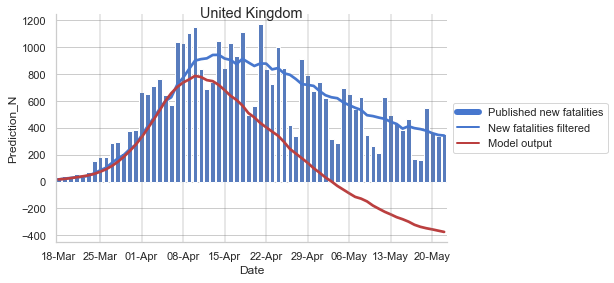

In [45]:
g = sns.FacetGrid(toPrint, height=4, aspect=2)#, hue='Country')#, col="United Kingdom")  legend_out = True,
g = g.map(sns.barplot, 'Date', 'dDeaths', color='#4777CE', order=None)#, hue='Country'
g = g.map(sns.pointplot, 'Date', 'dDeaths_filtered', markers="", color='#4777CE', order=None)
g = g.map(sns.pointplot, 'Date', 'Prediction_N', markers="", color="#bb3f3f", order=None)#.add_legend()
#g.add_legend()

#tickRange = range(0,max(toPrint['Day_0']),5)
#g.set(xticks=tickRange,xticklabels=tickRange)

tickRange = range(0,len(toPrint['Date_S']),7)
g.set(xticks=tickRange,xticklabels=toPrint['Date_S'].iloc[tickRange])


#Add vertical gridlines
for x in range(1,len(tickRange)):
    g.ax.axvline(g.ax.get_xticks()[x], alpha=0.25, color='grey')

g.fig.suptitle(chosenCountry)
custom_lines = [Line2D([0], [0], color='#4777CE', lw=6),
                Line2D([0], [0], color='#4777CE', lw=2),
                Line2D([0], [0], color="#bb3f3f", lw=2)]
plt.legend(custom_lines, ['Published new fatalities', 'New fatalities filtered', 'Model output'], 
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


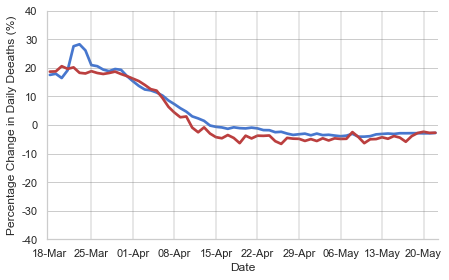

In [46]:
g = sns.FacetGrid(toPrint, height=4, aspect=2)#, hue='Country')#, col="United Kingdom")  legend_out = True,
#g = g.map(sns.barplot, 'Day_0', 'dDeaths', color='#4777CE')#, hue='Country'
g = g.map(sns.pointplot, 'Date', feature, markers="", color='#4777CE')
g = g.map(sns.pointplot, 'Date', 'Prediction', markers="", color="#bb3f3f")

tickRange = range(0,len(toPrint['Date_S']),7)
#tickRange = pd.date_range(min(toPrint['Date']),max(toPrint['Date']),freq='5D')
g.set(xticks=tickRange,xticklabels=toPrint['Date_S'].iloc[tickRange])

g.set(ylim=(-.4, .4))
g.set(yticklabels = (np.around(g.ax.get_yticks() * 100).astype(int)))
plt.ylabel('Percentage Change in Daily Deeaths (%)')#, fontsize=16)

#g.axes.xaxis.set_major_locator(ticker.MultipleLocator(5))
for x in range(1,len(tickRange)):
    g.ax.axvline(g.ax.get_xticks()[x], alpha=0.25, color='grey')

plt.show()

### Print out the model's input data (from Google's Community Mobility Reports)

In [47]:
G_features = ["Retail and Recreation", "Grocery and Pharmacy", "Parks", "Transit Stations", "Workplaces", "Residential"]
core_features = ['Country', 'Date', 'Day_0']

toPrintG = pd.DataFrame(columns = core_features)

toPrintG['Google Mobility Indicator'] = np.nan
toPrintG['% Change from baseline'] = np.nan

for x in G_features:
    
    currentLen = len(toPrintG)
    
    toPrintG = toPrintG.append(df_output.loc[:,core_features].reset_index(drop=True), sort=False).reset_index(drop=True)
    toPrintG.loc[currentLen:,'Google Mobility Indicator'] = x
    toPrintG.loc[currentLen:,'% Change from baseline'] = df_output[x][:].values #toPrint.loc[:,x].reset_index(drop=True)

#toPrintG

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'United Kingdom')

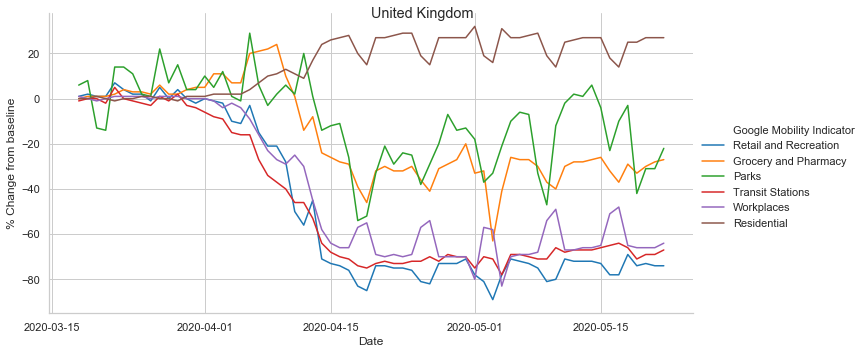

In [48]:
g = sns.relplot(x='Date', y='% Change from baseline', markers="", hue='Google Mobility Indicator', kind='line', estimator=None, aspect = 2, data = toPrintG[toPrintG.Country == chosenCountry])
g.fig.suptitle(chosenCountry)

# Prediction

In [49]:
a = df_output['dd_Deaths_f/dDeaths_f'][-dayOffset:].mean()*100
print('In the past 3 weeks, the average daily percentage percentage change in death is ' + str(a) + '%')

b = df_output['Prediction'][-dayOffset:].mean()*100
print('The ML model predicts ' + str(b) + '%')

In the past 3 weeks, the average daily percentage percentage change in death is -3.286064770873727%
The ML model predicts -4.319669950472617%


Get the un-merged data (without the trimmed dates)

In [50]:
googleCountryData = dfG_offset[dfG_offset['Country'] == chosenCountry].reset_index(drop=True)
JHCountryData = df_output[df_output['Country'] == chosenCountry].reset_index(drop=True)


Xp = scaler.transform(googleCountryData.drop(columns = ['Date', 'Country']))
Yp = model.predict(Xp)

And run the chosen ML model

In [51]:
Prediction = pd.DataFrame()#'Prediction', 'Date')
Prediction['Prediction'] = Yp
Prediction['Date'] = googleCountryData['Date']

PredictionC = Prediction.copy()

#Merging removes all dates not in both datasets (i.e. the prediction)
Prediction = pd.merge(Prediction, JHCountryData[['dd_Deaths_f/dDeaths_f', 'Date']], on=['Date']) 
Prediction = Prediction.rename(columns={'dd_Deaths_f/dDeaths_f': "Original"})

#So find the indexes of the future prediction
indexVal = np.where(PredictionC['Date'].values > Prediction['Date'][-1:].values)
#And append them back into the dataframe
Prediction  = Prediction.append(PredictionC.loc[indexVal[0],:], sort=False, ignore_index=True)

### Plot the prediction vs original data

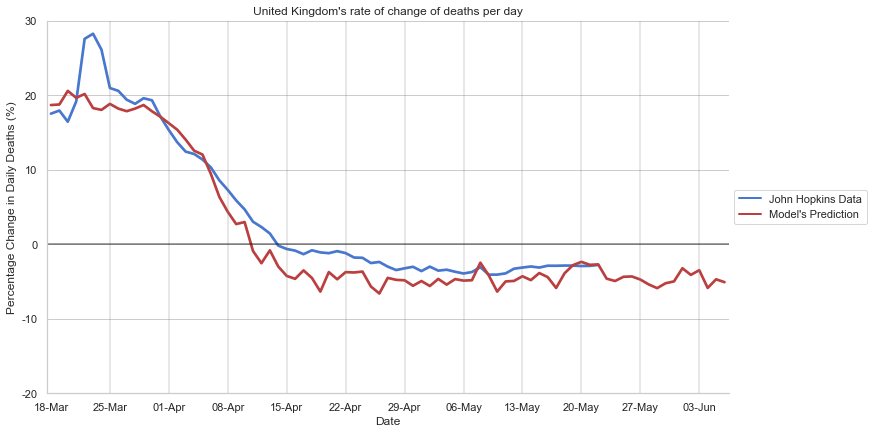

In [52]:
Prediction['Date_S'] = Prediction['Date'].dt.strftime("%d-%b")
g = sns.FacetGrid(Prediction, height=6, aspect=2)
g = g.map(sns.pointplot, 'Date', 'Original', markers="", color='#4777CE', order=None)
g = g.map(sns.pointplot, 'Date', 'Prediction', markers="", color="#bb3f3f", order=None)

tickRange = range(0,len(Prediction['Date_S']),7)

g.set(xticks=tickRange,xticklabels=Prediction['Date_S'].iloc[tickRange])

g.set(ylim=(-.2, .3))
g.set(yticklabels = (np.around(g.ax.get_yticks() * 100).astype(int)))
plt.ylabel('Percentage Change in Daily Deaths (%)')#, fontsize=16)

#Manually add vertical gridlines
for x in range(1,len(tickRange)):
    g.ax.axvline(g.ax.get_xticks()[x], alpha=0.25, color='grey')

#Add a black line for y=0 to make it clearer
x = np.where(g.ax.get_yticks() == 0)
g.ax.axhline(g.ax.get_yticks()[x], alpha=0.5, color='black')


#Add legend
custom_lines = [Line2D([0], [0], color='#4777CE', lw=2),
                Line2D([0], [0], color="#bb3f3f", lw=2)]
plt.legend(custom_lines, ['John Hopkins Data', "Model's Prediction"], loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(chosenCountry + "'s rate of change of deaths per day")

plt.savefig('predictionUK.png', bbox_inches='tight', dpi=300)
plt.show()

In [53]:
#To calculate predicted average daily change of deaths, first calculate the index of the last JH datapoint 
latestJHDate = np.where(Prediction['Date'].values == JHCountryData['Date'][-1:].values)

c = Prediction['Prediction'][latestJHDate[0][0]:].mean()*100
print('The ML model predicts ' + str(b) + '% since the most recent John Hopkins data point')

The ML model predicts -4.319669950472617% since the most recent John Hopkins data point


### Plot the predicted vs actual daily deaths

Predict the number of daily deaths

In [54]:
Prediction.loc[:,'per Day'] = np.nan
Prediction.loc[:,'Change per Day'] = np.nan
temp = df_output[df_output['Country'] == chosenCountry].reset_index(drop=True)

Prediction.loc[0, 'per Day'] = temp.dDeaths_filtered.iloc[0]
Prediction.loc[0,'Change per Day'] = Prediction.loc[0, 'Prediction'] * Prediction.loc[0, 'per Day']

calc = pd.DataFrame()

for x in Prediction.index[1:]:
   
    Prediction.loc[x,'per Day'] = abs(Prediction.loc[x-1,'per Day'] / (1 - Prediction.loc[x,'Prediction']))

#for x in Prediction.index[1:]:

#    if x < dayOffset:
#        Prediction.loc[x,'per Day'] = Prediction.loc[x-1,'per Day'] / (1 - Prediction.loc[x,'Prediction'])
#    else:
#        calc.loc[x-dayOffset, 'per Day'] = temp.dDeaths_filtered.iloc[x-dayOffset]

#        for y in range(x-dayOffset+1,x+1):

#            calc.loc[y,'per Day'] = calc.loc[y-1,'per Day'] / (1 - Prediction.loc[y,'Prediction'])

        #x should equal y...
#        Prediction.loc[x,'per Day'] = calc.loc[x,'per Day']

In [55]:
Prediction['Raw per Day'] = temp['dDeaths']
Prediction['Original per Day'] = temp['dDeaths_filtered']

And plot the results

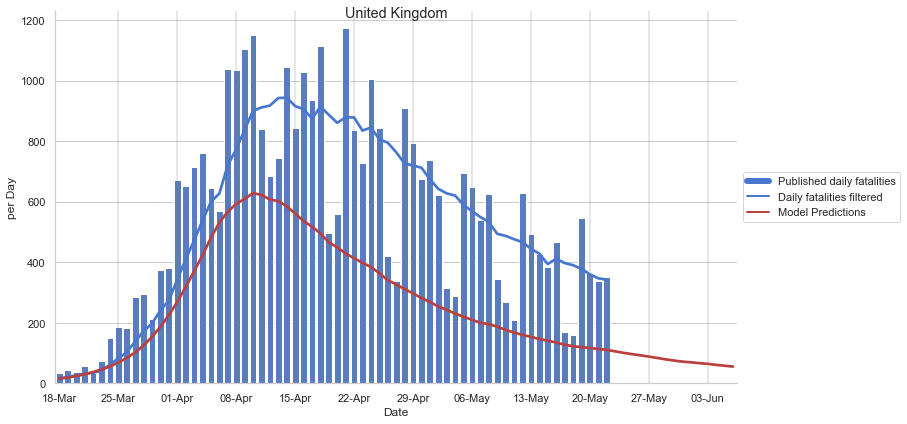

In [56]:
g = sns.FacetGrid(Prediction, height=6, aspect=2)#, hue='Country')#, col="United Kingdom")  legend_out = True,
g = g.map(sns.barplot, 'Date', 'Raw per Day', color='#4777CE', order=None)#, hue='Country'
g = g.map(sns.pointplot, 'Date', 'Original per Day', markers="", color='#4777CE', order=None)
g = g.map(sns.pointplot, 'Date', 'per Day', markers="", color="#bb3f3f", order=None)#.add_legend()
#g.add_legend()

#tickRange = range(0,max(toPrint['Day_0']),5)
#g.set(xticks=tickRange,xticklabels=tickRange)

tickRange = range(0,len(Prediction['Date_S']),7)
g.set(xticks=tickRange,xticklabels=Prediction['Date_S'].iloc[tickRange])


#Add vertical gridlines
for x in range(1,len(tickRange)):
    g.ax.axvline(g.ax.get_xticks()[x], alpha=0.25, color='grey')

g.fig.suptitle(chosenCountry)
custom_lines = [Line2D([0], [0], color='#4777CE', lw=6),
                Line2D([0], [0], color='#4777CE', lw=2),
                Line2D([0], [0], color="#bb3f3f", lw=2)]
plt.legend(custom_lines, ['Published daily fatalities', 'Daily fatalities filtered', 'Model Predictions'],
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

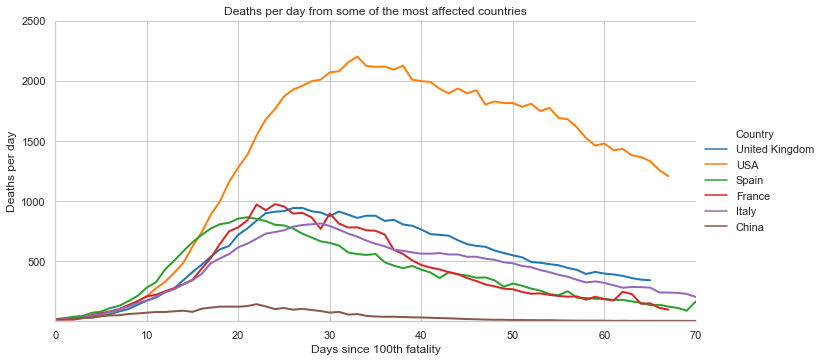

In [57]:
key = ['United Kingdom', 'USA', 'Spain', 'France', 'Italy' ,  'China']
#China is included in this list as it was the first country to be effected by COVID-19 

g = sns.relplot(dayVal, 'dDeaths_filtered', kind='line', estimator=None, hue = 'Country', hue_order = key, data = dfJ, aspect = 2, lw=2)# color='#4777CE', order=None)
#plt.yscale('log')
g.set(xlim=(0, 70))
g.set(ylim=(1, 2500))
plt.title('Deaths per day from some of the most affected countries')
plt.xlabel('Days since ' + str(minD) +'th fatality')
plt.ylabel('Deaths per day')

plt.savefig('perDayAll.png', bbox_inches='tight', dpi=300)
plt.show()



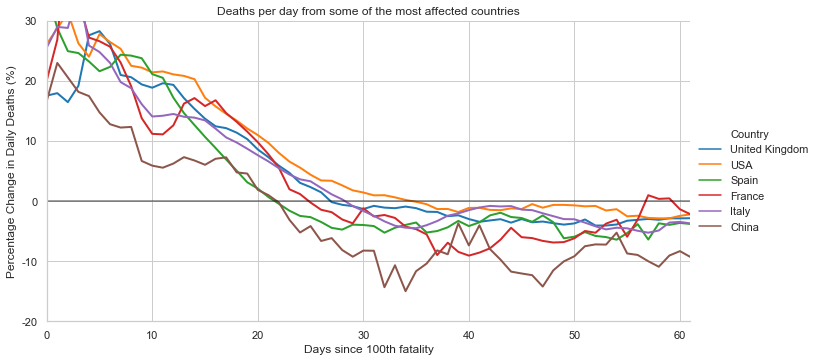

In [62]:
key = ['United Kingdom', 'USA', 'Spain', 'France', 'Italy' ,  'China']
#China is included in this list as it was the first country to be effected by COVID-19 

g = sns.relplot(dayVal, 'dd_Deaths_f/dDeaths_f', kind='line', estimator=None, hue = 'Country', hue_order = key, data = dfJ, aspect = 2, lw=2)# color='#4777CE', order=None)
#plt.yscale('log')
g.set(xlim=(0, 61))
g.set(ylim=(-.2, .3))
plt.title('Deaths per day from some of the most affected countries')
plt.xlabel('Days since ' + str(minD) +'th fatality')

g.set(yticklabels = (np.around(g.ax.get_yticks() * 100).astype(int)))
plt.ylabel('Percentage Change in Daily Deaths (%)')#, fontsize=16)

#Add a black line for y=0 to make it clearer
x = np.where(g.ax.get_yticks() == 0)
g.ax.axhline(g.ax.get_yticks()[x], alpha=0.5, color='black')


plt.savefig('changePerDayAll.png', bbox_inches='tight', dpi=300)
plt.show()

In [59]:
dfJ_t.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,132,136,153,168,169,173,178,187,193,205
1,Albania,0,0,0,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,Algeria,0,0,0,0,0,0,0,0,0,...,522,529,536,542,548,555,561,568,575,582
3,Andorra,0,0,0,0,0,0,0,0,0,...,49,49,49,51,51,51,51,51,51,51
4,Angola,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,3,3,3,3,3


In [60]:
total = pd.DataFrame()


colIndex = dfJ_t.columns[1:]


total.loc[0, 'Count'] = dfJ_t[colIndex[0]].sum()
total.loc[0, 'Day'] = 0

y=1
for x in range(1,len(colIndex)):
    total.loc[y, 'Count'] = dfJ_t[colIndex[x]].sum() - dfJ_t[colIndex[x-1]].sum()
    total.loc[y, 'Day'] = y
    y = y + 1



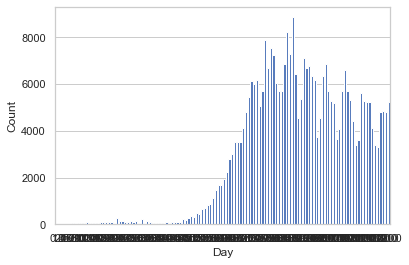

In [61]:
g = sns.barplot('Day', 'Count', color='#4777CE', order=None, data = total)